### (1) Import basic libs

In [1]:
#basic libs for data processing
import pandas as pd
import numpy as np
from itertools import product
from sklearn.preprocessing import LabelEncoder
import calendar

#basic libs for data vizualisations
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
%pwd

'C:\\Users\\he\\Desktop\\Coursera_HowToWinAKaggleCompetition\\16_FinalProject\\input'

### (2) Import data

In [3]:
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
sales = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv.gz')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
item_cats = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
sample_submission = pd.read_csv("../input/competitive-data-science-predict-future-sales/sample_submission.csv")

### (3) Basic EDA

In [4]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [5]:
test.shape

(214200, 3)

In [6]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
sales.shape

(2935849, 6)

In [8]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [9]:
shops.shape

(60, 2)

In [10]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [11]:
items.shape

(22170, 3)

In [12]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [13]:
item_cats.shape

(84, 2)

In [14]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [15]:
sample_submission.shape

(214200, 2)

So test shape and sample submission shape is equal. Let's explore a bit further and introduce "train" set...

##### remove outliers

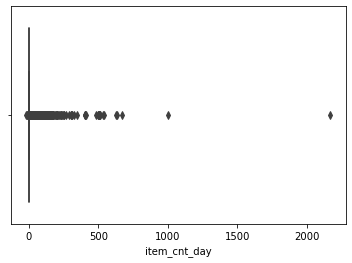

In [16]:
sns.boxplot(x=sales.item_cnt_day)

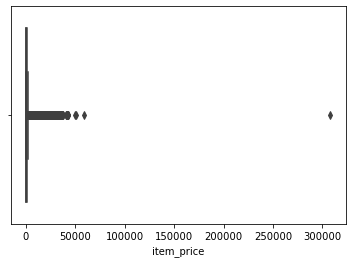

In [17]:
sns.boxplot(x=sales.item_price)

In [18]:
train = sales[(sales.item_price < 100000) & (sales.item_price > 0)]
train = train[sales.item_cnt_day < 600]

C:\ProgramData\Anaconda3\envs\venv37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


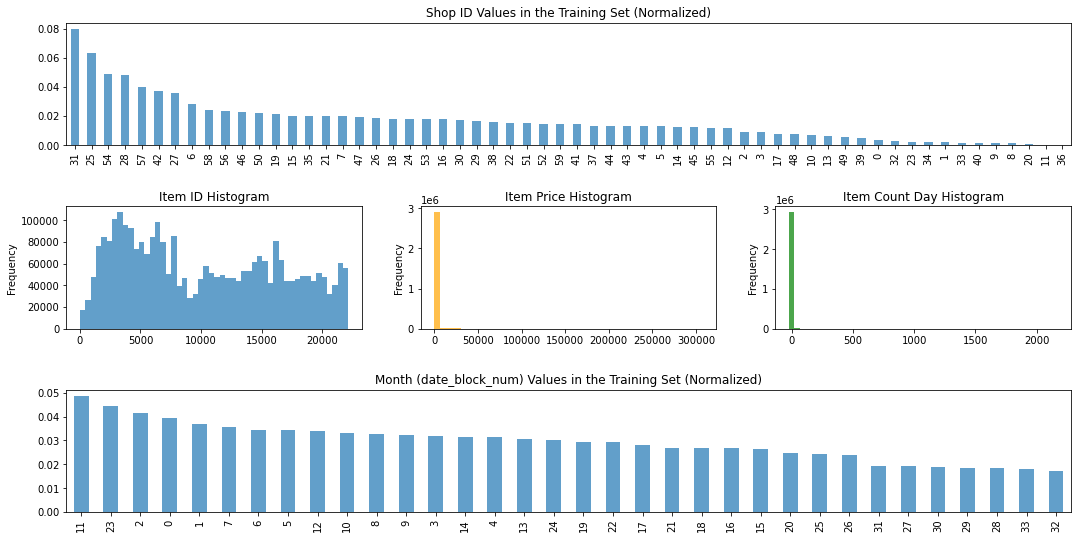

In [19]:
# EDA training set
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
sales['shop_id'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Shop ID Values in the Training Set (Normalized)')

plt.subplot2grid((3,3), (1,0))
sales['item_id'].plot(kind='hist', bins=50, alpha=0.7)
plt.title('Item ID Histogram')

plt.subplot2grid((3,3), (1,1))
sales['item_price'].plot(kind='hist', bins=50, alpha=0.7, color='orange')
plt.title('Item Price Histogram')

plt.subplot2grid((3,3), (1,2))
sales['item_cnt_day'].plot(kind='hist', bins=50, alpha=0.7, color='green')
plt.title('Item Count Day Histogram')

plt.subplot2grid((3,3), (2,0), colspan = 3)
sales['date_block_num'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Month (date_block_num) Values in the Training Set (Normalized)')

plt.show()

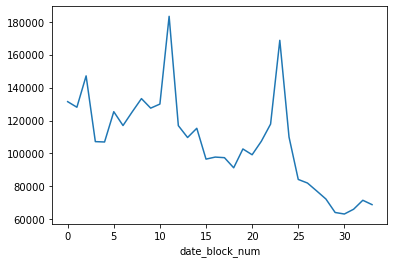

In [20]:
# item counts over months
train.groupby("date_block_num")["item_cnt_day"].sum().plot()

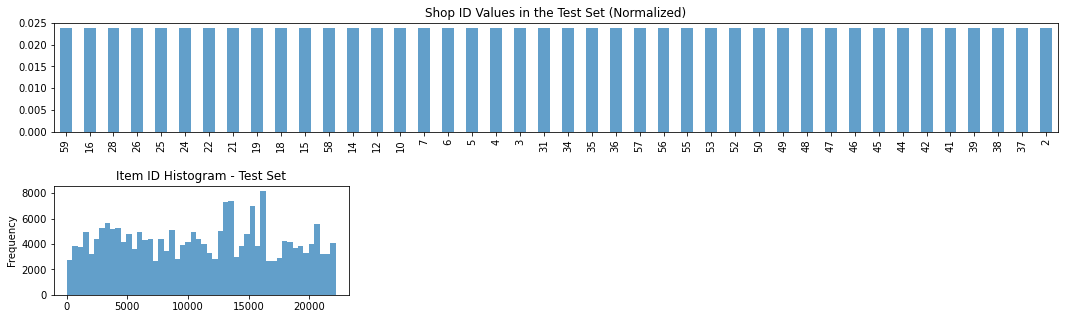

In [21]:
# EDA for test set
fig = plt.figure(figsize=(18,8))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
test['shop_id'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Shop ID Values in the Test Set (Normalized)')

plt.subplot2grid((3,3), (1,0))
test['item_id'].plot(kind='hist', bins=50, alpha=0.7)
plt.title('Item ID Histogram - Test Set')

plt.show()

observations:
- The Shop Id's are evenly spread out, unlike the training set. 
- The font size of labels tells that there are certain Shop Id's missing in the test set as the bars in the training set 'shop_id' plot were more tightly packed.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000022F400EEFC8>],
      dtype=object)

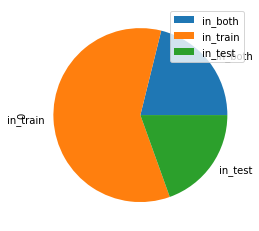

In [22]:
# distribution of shop_item combinations in train and test set
train_unique = train.groupby(["shop_id", "item_id"]).size()
test_unique = test.groupby(["shop_id", "item_id"]).size()

train_unique = pd.DataFrame({"in_train":True}, index=train_unique.index)
test_unique = pd.DataFrame({"in_test":True}, index=test_unique.index)

combined = pd.merge(train_unique, test_unique, on=["shop_id", "item_id"], how="outer").fillna(False)

combined["in_both"] = combined["in_train"] & combined["in_test"]

num_in_both = sum(combined["in_both"] == True)
num_in_train = sum((combined["in_train"] == True) & (combined["in_test"] == False))
num_in_test = sum((combined["in_test"] == True) & (combined["in_train"] == False))

pd.DataFrame({"in_both":[num_in_both], 
              "in_train": [num_in_train],
              "in_test": [num_in_test]}).T.plot.pie(subplots=True)

In [23]:
num_in_both

111404

In [24]:
num_in_train

312719

In [25]:
num_in_test

102796

Hence, for the most of the items in the test set target value should be zero.

##### unique shops?

In [26]:
print('len of shops: %d' % len(shops))
print('len of unique shops: %d' % len(shops.shop_name.unique()))

len of shops: 60
len of unique shops: 60


In [27]:
shops.shop_name

0                       !Якутск Орджоникидзе, 56 фран
1                       !Якутск ТЦ "Центральный" фран
2                                    Адыгея ТЦ "Мега"
3                      Балашиха ТРК "Октябрь-Киномир"
4                            Волжский ТЦ "Волга Молл"
5                              Вологда ТРЦ "Мармелад"
6                          Воронеж (Плехановская, 13)
7                              Воронеж ТРЦ "Максимир"
8                        Воронеж ТРЦ Сити-Парк "Град"
9                                   Выездная Торговля
10                         Жуковский ул. Чкалова 39м?
11                         Жуковский ул. Чкалова 39м²
12                                Интернет-магазин ЧС
13                                Казань ТЦ "Бехетле"
14                            Казань ТЦ "ПаркХаус" II
15                               Калуга ТРЦ "XXI век"
16                                   Коломна ТЦ "Рио"
17                      Красноярск ТЦ "Взлетка Плаза"
18                          

In [28]:
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

train.loc[train.shop_id == 40, 'shop_id'] = 39
test.loc[test.shop_id == 40, 'shop_id'] = 39

train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

### (4) Basic dataset (train and test combined for simplicity and data quality assurance)

In [29]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(sales.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

What we know now:
- Test set is a product of some shops and some items within month 34 (November 2015). 
- There are 5100 items * 42 shops = 214200 pairs. 
- 363 items are new compared to the train. 
- Sales set contains only pairs which were sold or returned in the past. 

The main idea is to calculate monthly sales and extend it with zero sales for each unique pair within the month. This way sales data will be similar to test data.

Start with...

In [30]:
train['date_block_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int64)

In [31]:
cur_shops = train.loc[sales['date_block_num'] == train['date_block_num'].unique()[0], 'shop_id'].unique()
cur_items = train.loc[sales['date_block_num'] == train['date_block_num'].unique()[0], 'item_id'].unique()
list(product(*[cur_shops, cur_items, [train['date_block_num'].unique()[0]]]))

[(59, 22154, 0),
 (59, 2552, 0),
 (59, 2554, 0),
 (59, 2555, 0),
 (59, 2564, 0),
 (59, 2565, 0),
 (59, 2572, 0),
 (59, 2573, 0),
 (59, 2574, 0),
 (59, 2593, 0),
 (59, 2604, 0),
 (59, 2607, 0),
 (59, 2609, 0),
 (59, 2548, 0),
 (59, 2611, 0),
 (59, 2546, 0),
 (59, 2515, 0),
 (59, 2705, 0),
 (59, 2715, 0),
 (59, 2716, 0),
 (59, 2719, 0),
 (59, 2720, 0),
 (59, 2473, 0),
 (59, 2480, 0),
 (59, 2731, 0),
 (59, 2746, 0),
 (59, 2748, 0),
 (59, 2522, 0),
 (59, 2614, 0),
 (59, 2798, 0),
 (59, 2833, 0),
 (59, 2835, 0),
 (59, 2836, 0),
 (59, 2844, 0),
 (59, 2845, 0),
 (59, 2847, 0),
 (59, 2848, 0),
 (59, 2854, 0),
 (59, 2857, 0),
 (59, 2920, 0),
 (59, 2795, 0),
 (59, 2808, 0),
 (59, 2628, 0),
 (59, 2629, 0),
 (59, 2631, 0),
 (59, 2640, 0),
 (59, 2822, 0),
 (59, 2704, 0),
 (59, 2703, 0),
 (59, 2088, 0),
 (59, 2090, 0),
 (59, 2092, 0),
 (59, 2100, 0),
 (59, 2102, 0),
 (59, 2103, 0),
 (59, 2106, 0),
 (59, 2108, 0),
 (59, 2111, 0),
 (59, 2117, 0),
 (59, 2121, 0),
 (59, 2122, 0),
 (59, 2123, 0),
 (59, 2

Ok this works. Let's do the full exercise...

In [32]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

df = [] 
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

df = pd.DataFrame(np.vstack(df), columns = index_cols,dtype=np.int32)

#Add month sales
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=index_cols, how='left')
df['item_cnt_month'] = (df['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0


In [33]:
#add test data ()
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
df = pd.concat([df, test], ignore_index=True, sort=False, keys=index_cols)
df.fillna(0, inplace=True)

### (5) Feature engineering (and encoding if useful; we will be using tree based models exclusively)

In [34]:
#item category
items = pd.merge(items, item_cats, on='item_category_id')

items['item_category'] = items['item_category_name'].apply(lambda x: x.split('-')[0])

items['item_category_common'] = LabelEncoder().fit_transform(items['item_category'])

items['item_category_code'] = LabelEncoder().fit_transform(items['item_category_name'])
items = items[['item_id', 'item_category_common', 'item_category_code']]
df = pd.merge(df, items, on=['item_id'], how='left')

In [35]:
#days features
def count_days(date_block_num):
    year = 2013 + date_block_num // 12
    month = 1 + date_block_num % 12
    weeknd_count = len([1 for i in calendar.monthcalendar(year, month) if i[6] != 0])
    days_in_month = calendar.monthrange(year, month)[1]
    return weeknd_count, days_in_month, month

map_dict = {i: count_days(i) for i in range(35)}

df['weeknd_count'] = df['date_block_num'].apply(lambda x: map_dict[x][0])
df['days_in_month'] = df['date_block_num'].apply(lambda x: map_dict[x][1])

In [36]:
#new item sold
first_item_block = df.groupby(['item_id'])['date_block_num'].min().reset_index()
first_item_block['item_first_interaction'] = 1

first_shop_item_buy_block = df[df['date_block_num'] > 0].groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
first_shop_item_buy_block['first_date_block_num'] = first_shop_item_buy_block['date_block_num']

In [37]:
#item sold before
df = pd.merge(df, first_item_block[['item_id', 'date_block_num', 'item_first_interaction']], on=['item_id', 'date_block_num'], how='left')
df = pd.merge(df, first_shop_item_buy_block[['item_id', 'shop_id', 'first_date_block_num']], on=['item_id', 'shop_id'], how='left')

df['first_date_block_num'].fillna(100, inplace=True)
df['shop_item_sold_before'] = (df['first_date_block_num'] < df['date_block_num']).astype('int8')
df.drop(['first_date_block_num'], axis=1, inplace=True)

df['item_first_interaction'].fillna(0, inplace=True)
df['shop_item_sold_before'].fillna(0, inplace=True)
 
df['item_first_interaction'] = df['item_first_interaction'].astype('int8')  
df['shop_item_sold_before'] = df['shop_item_sold_before'].astype('int8') 

In [38]:
#date category median item count
group = df.groupby(['date_block_num', 'item_category_common']).agg({'item_cnt_month': ['median']})
group.columns = [ 'date_cat_median_item_cnt' ]
group.reset_index(inplace=True)

df = pd.merge(df, group, on=['date_block_num','item_category_common'], how='left')
df['date_cat_median_item_cnt'] = df['date_cat_median_item_cnt'].astype(np.float16)

In [39]:
#lag features
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)] = df[col+'_lag_'+str(i)].astype('float16')
    return df

In [40]:
df = lag_feature(df, [1, 2, 3, 12], 'item_cnt_month')

In [41]:
#avg shop and item price
index_cols = ['shop_id', 'item_id', 'date_block_num']
group = train.groupby(index_cols)['item_price'].mean().reset_index().rename(columns={"item_price": "avg_shop_price"}, errors="raise")
df = pd.merge(df, group, on=index_cols, how='left')

df['avg_shop_price'] = (df['avg_shop_price']
                                .fillna(0)
                                .astype(np.float16))

index_cols = ['item_id', 'date_block_num']
group = train.groupby(['date_block_num','item_id'])['item_price'].mean().reset_index().rename(columns={"item_price": "avg_item_price"}, errors="raise")


df = pd.merge(df, group, on=index_cols, how='left')
df['avg_item_price'] = (df['avg_item_price']
                                .fillna(0)
                                .astype(np.float16))

df['item_shop_price_avg'] = (df['avg_shop_price'] - df['avg_item_price']) / df['avg_item_price']
df['item_shop_price_avg'].fillna(0, inplace=True)

df = lag_feature(df, [1, 2, 3], 'item_shop_price_avg') #avg item shop price one year ago is not interesting for me
df.drop(['avg_shop_price', 'avg_item_price', 'item_shop_price_avg'], axis=1, inplace=True)

In [42]:
# target encoding for items for last 3 months and month one year ago 
item_id_target_mean = df.groupby(['date_block_num','item_id'])['item_cnt_month'].mean().reset_index().rename(columns={"item_cnt_month": "item_target_enc"}, errors="raise")
df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id'], how='left')

df['item_target_enc'] = (df['item_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3, 12], 'item_target_enc')
df.drop(['item_target_enc'], axis=1, inplace=True)

In [43]:
#add avg category sales for last 3 months and month one year ago for new items
item_id_target_mean = df[df['item_first_interaction'] == 1].groupby(['date_block_num','item_category_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "new_item_cat_avg"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_category_code'], how='left')

df['new_item_cat_avg'] = (df['new_item_cat_avg']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3, 12], 'new_item_cat_avg')
df.drop(['new_item_cat_avg'], axis=1, inplace=True)

##### further cleaning

In [44]:
#remove data for first 3 month
df.fillna(0, inplace=True)
df = df[(df['date_block_num'] > 2)]
df.head()

,shop_id,item_id,date_block_num,item_cnt_month,ID,item_category_common,item_category_code,weeknd_count,days_in_month,item_first_interaction,...,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3,item_target_enc_lag_12,new_item_cat_avg_lag_1,new_item_cat_avg_lag_2,new_item_cat_avg_lag_3,new_item_cat_avg_lag_12
1122795,25,8092,3,3.0,0.0,11,40,4,30,0,...,-1.000000,0.047455,0.586914,0.630371,1.444336,0.0,0.643066,0.517578,0.293945,0.0
1122796,25,7850,3,3.0,0.0,8,30,4,30,0,...,0.025116,0.023132,1.869141,1.456055,3.089844,0.0,3.351562,0.745605,1.126953,0.0
1122797,25,8051,3,3.0,0.0,14,66,4,30,0,...,-1.000000,-1.000000,0.043488,0.130493,0.133301,0.0,0.027664,0.036224,0.160645,0.0
1122798,25,8088,3,1.0,0.0,13,55,4,30,0,...,0.283936,-1.000000,0.130493,0.043488,0.066650,0.0,0.333252,0.108521,0.208130,0.0
1122799,25,8089,3,1.0,0.0,13,55,4,30,0,...,0.038483,-1.000000,0.478271,0.260986,0.177734,0.0,0.333252,0.108521,0.208130,0.0


In [45]:
df.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'ID',
       'item_category_common', 'item_category_code', 'weeknd_count',
       'days_in_month', 'item_first_interaction', 'shop_item_sold_before',
       'date_cat_median_item_cnt', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_12',
       'item_shop_price_avg_lag_1', 'item_shop_price_avg_lag_2',
       'item_shop_price_avg_lag_3', 'item_target_enc_lag_1',
       'item_target_enc_lag_2', 'item_target_enc_lag_3',
       'item_target_enc_lag_12', 'new_item_cat_avg_lag_1',
       'new_item_cat_avg_lag_2', 'new_item_cat_avg_lag_3',
       'new_item_cat_avg_lag_12'],
      dtype='object')

### (6) Saving for further usage to pkl

In [46]:
df.drop(['ID'], axis=1, inplace=True, errors='ignore')
df.to_pickle('data_prep_final.pkl')